# Diagnostics - PowerSpec

In this notebook, we are going to look at some simulations that we have available and analyze some of the statistical properties of the datasets. 

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import sys
import math
from pathlib import Path

import torch
import torch.nn as nn

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

import xarray as xr
try:
    import powerspec as ps
except ModuleNotFoundError:
    !pip install powerspec
    import powerspec as ps    
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Test Data

In [4]:
from alti_tools._src.data.ssh import download_ssh_toy

In [6]:
download_ssh_toy("test")

In [10]:
data = xr.open_dataset("test_data.nc")
data

<xarray.Dataset>
Dimensions:        (y: 730, x: 598)
Coordinates:
    nav_lon        (y, x) float32 ...
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] ...
    nav_lat        (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    ssh            (y, x) float32 ...
    u              (y, x) float32 ...
    v              (y, x) float32 ...
    u15            (y, x) float32 ...

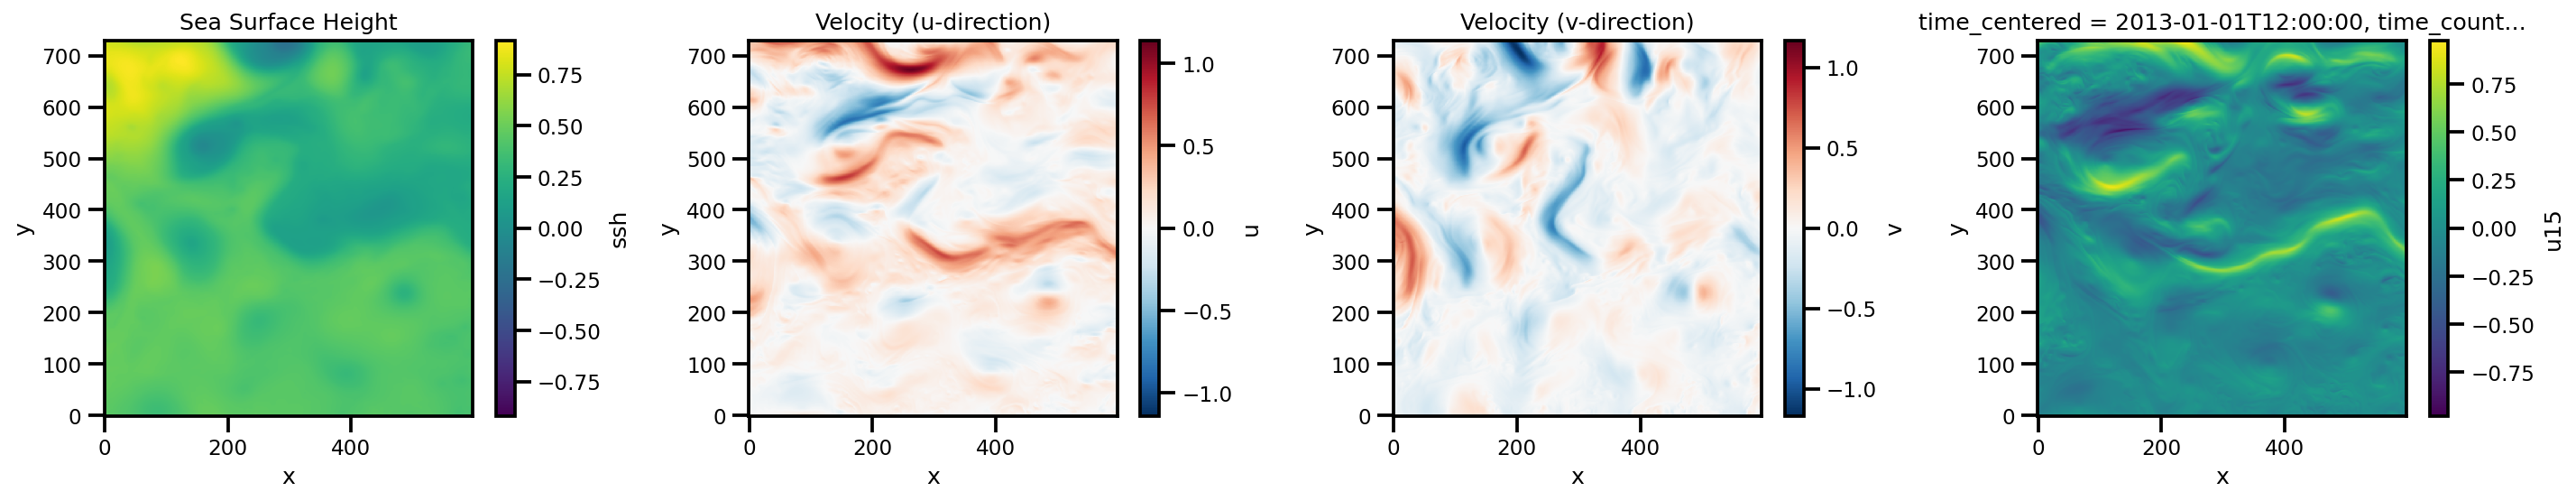

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,4))

# sea surface height
data.ssh.plot(cmap="viridis", ax=ax[0])
ax[0].set(title="Sea Surface Height")

# geostrophic velocity, u-direction
data.u.plot(cmap="RdBu_r", ax=ax[1])
ax[1].set(title="Velocity (u-direction)")

# geostrophic velocity, v-direction
data.v.plot(cmap="RdBu_r", ax=ax[2])
ax[2].set(title="Velocity (v-direction)")

# vorticity
data.u15.plot(cmap="viridis", ax=ax[3])

plt.tight_layout()
plt.show()

In [30]:
data["velocity"] = 0.5 * (data.u**2 + data.v**2)


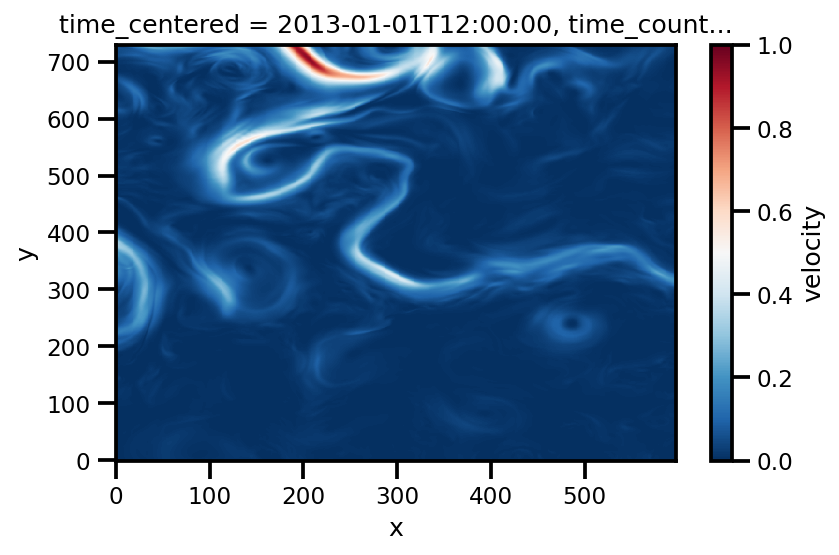

In [39]:
fig, ax = plt.subplots()

data.velocity.plot(cmap="RdBu_r", ax=ax, vmin=0.0, vmax=1.0, robust=True)

plt.tight_layout()
plt.show()

In [48]:
ssh = data.ssh
u = data.u
v = data.v
u15 = data.u15

In [49]:
# PSD
wavenumber, psd = ps.wavenumber_spectra(ssh.to_masked_array(), ssh.nav_lon.data, ssh.nav_lat.data)

# Flux
wavenumber, flux = ps.spectra_flux(u.to_masked_array(),v.to_masked_array(), u.nav_lon.data, u.nav_lat.data)

# Cross Spectra
wavenumber, cs = ps.cross_spectra(u.to_masked_array(),u15.to_masked_array(), u.nav_lon.data, u.nav_lat.data,Normalize=True)

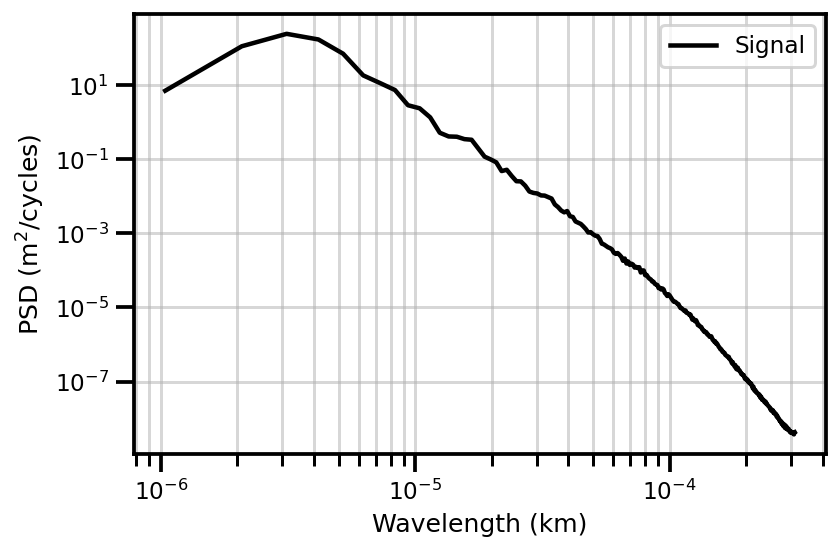

In [50]:
fig, ax = plt.subplots()

ax.plot( 
    wavenumber,
    psd,
    label="Signal", color="black"
)

ax.set(
    yscale="log", xscale="log",
    xlabel="Wavelength (km)",
    ylabel="PSD (m$^{2}$/cycles)",
    # xlim=(1e0, 1e4),
)
# ax.invert_yaxis()
ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()

## NATL60 Data

### Sea Surface Height

* [Source](https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/ocean-data-challenges/dc_data1/dc_ref/catalog.html)

In [51]:
download_ssh_toy("natl60")

In [12]:
# # get directoru
# data_path = Path("/Users/eman/.CMVolumes/cal1_workdir/data/dc_2020/dc_ref")

# # list all files in directory
# data_names = list(data_path.glob("*.nc"))

# # sample name
# data_name = data_path.joinpath("NATL60-CJM165_GULFSTREAM_y2012*.nc")

In [52]:
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("NATL60-CJM165_GULFSTREAM_y2013m09d30.1h_SSH.nc")
ds_grid

<xarray.Dataset>
Dimensions:   (time: 24, lat: 600, lon: 600)
Coordinates:
  * lon       (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time      (time) datetime64[ns] 2013-09-30T00:30:00 ... 2013-09-30T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 ...
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

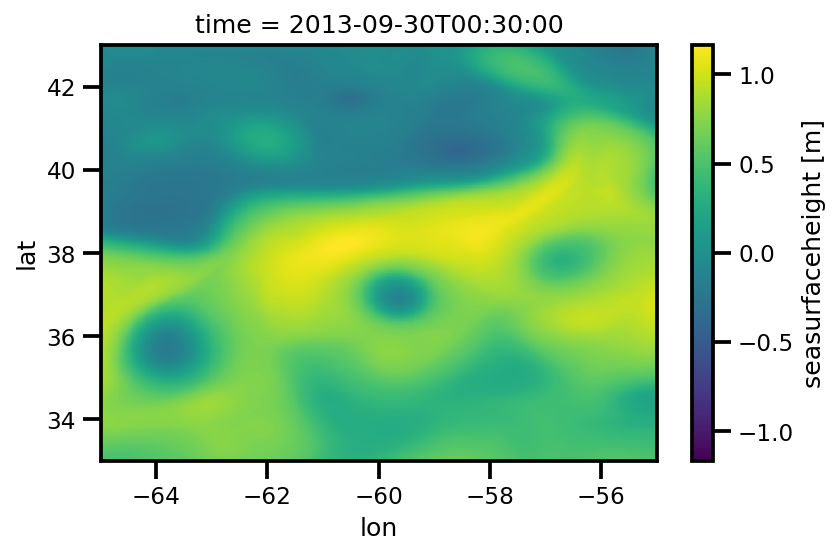

In [55]:
fig, ax = plt.subplots()

ds_grid.isel(time=0).sossheig.plot(ax=ax, cmap="viridis")

plt.tight_layout()
plt.show()

In [57]:
ssh = ds_grid.sossheig

lon_grid, lat_grid = np.meshgrid(ssh.lon, ssh.lat)

In [58]:
from tqdm.notebook import trange

In [59]:
# - compute hourly spectral then estimate the mean
psd = {}
wavenumber = {}
psd["natl60"] = []

n_timesteps = len(ds_grid.time)

for t in trange(n_timesteps):
    wavenumber["natl60"],psd_ = ps.wavenumber_spectra(
        ssh[t].to_masked_array(),
        lon_grid,
        lat_grid,
        # window="Hanning", detrend="Both"
    )
    psd["natl60"].append(psd_)

  0%|          | 0/24 [00:00<?, ?it/s]

We need to take an average wrt time.

In [60]:
psd["natl60"] = np.array(psd["natl60"]).mean(axis=0)

#### WaveNumber

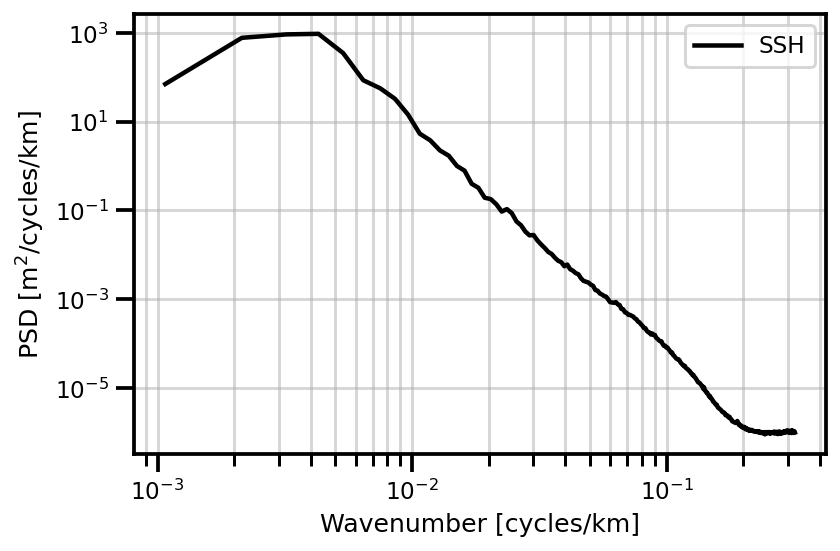

In [64]:
fig, ax = plt.subplots()

ax.plot( 
    wavenumber["natl60"]*1e3,
    psd["natl60"],
    label="SSH", color="black"
)

ax.set(
    yscale="log", xscale="log",
    xlabel="Wavenumber [cycles/km]",
    ylabel="PSD [m$^{2}$/cycles/km]",
    # xlim=(1e0, 1e4),
)
# ax.invert_yaxis()
ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()

#### Wavelength

Mostly for visualization purposes. This is much easier to read the actual wavelength of the respective distances.

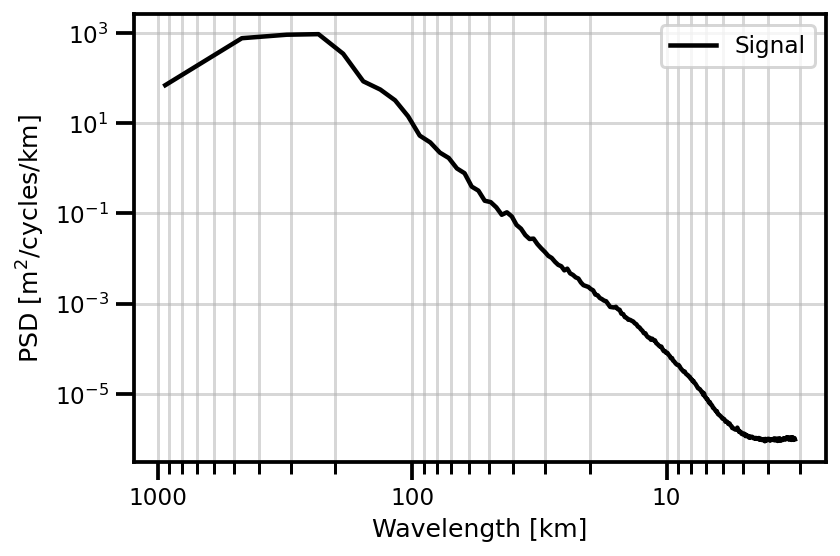

In [78]:
fig, ax = plt.subplots()

ax.plot( 
    1/(wavenumber["natl60"]*1e3),
    psd["natl60"],
    label="Signal", color="black"
)

ax.set(
    yscale="log", xscale="log",
    xlabel="Wavelength [km]",
    ylabel="PSD [m$^{2}$/cycles/km]",
    # xtick
    # xlim=(1e0, 1e4),
)
ax.xaxis.set_major_formatter('{x:.0f}')
ax.invert_xaxis()
ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()

#### Wavenumber & Wavelength

**Source**: 
* https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
* https://matplotlib.org/stable/gallery/ticks/tick-formatters.html

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_14760/88541444.py:15: RuntimeWarning: divide by zero encountered in true_divide
  secax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))


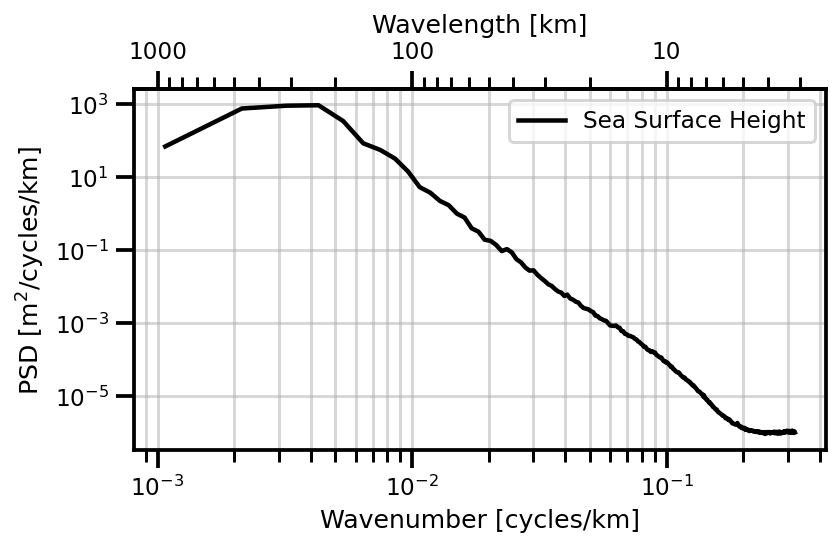

In [100]:
fig, ax = plt.subplots()

ax.plot( 
    (wavenumber["natl60"]*1e3),
    psd["natl60"],
    label="Sea Surface Height", color="black"
)

ax.set(
    yscale="log", xscale="log",
    xlabel="Wavenumber [cycles/km]",
    ylabel="PSD [m$^{2}$/cycles/km]",
)

secax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
secax.xaxis.set_major_formatter('{x:.0f}')
secax.set(xlabel="Wavelength [km]")


ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()

## Reconstruction Datasets

In [121]:
download_ssh_toy("4dvarnet")
# download_ssh_toy("duacs")
download_ssh_toy("miost")

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-02T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 ...

In [113]:

# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc")
ds_grid

ssh = ds_grid.ssh

lon_grid, lat_grid = np.meshgrid(ssh.lon, ssh.lat)

# - compute hourly spectral then estimate the mean
psd["4dvarnet"] = []
n_timesteps = len(ds_grid.time)

for t in trange(n_timesteps):
    wavenumber["4dvarnet"],psd_ = ps.wavenumber_spectra(
        ssh[t].to_masked_array(),
        lon_grid,
        lat_grid
    )
    psd["4dvarnet"].append(psd_) 
psd["4dvarnet"] = np.array(psd["4dvarnet"]).mean(axis=0)

  0%|          | 0/42 [00:00<?, ?it/s]

In [123]:
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("2020a_SSH_mapping_NATL60_MIOST_swot_en_j1_tpn_g2.nc")
ds_grid

<xarray.Dataset>
Dimensions:  (time: 93, lat: 152, lon: 203)
Coordinates:
  * lon      (lon) float32 -70.1 -70.0 -69.9 -69.8 ... -50.2 -50.1 -50.0 -49.9
  * lat      (lat) float32 30.0 30.1 30.2 30.3 30.4 ... 44.7 44.8 44.9 45.0 45.1
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-01-01
Data variables:
    gssh     (time, lat, lon) float32 ...
Attributes:
    description:   Miost analysis 
    history:      Sat Jan 23 17:56:19 2021: ncap -s ssh=Hls+Hss+MDH data_chal...
    NCO:          4.6.6

In [124]:
ssh = ds_grid.gssh

lon_grid, lat_grid = np.meshgrid(ssh.lon, ssh.lat)

# - compute hourly spectral then estimate the mean
psd["miost"] = []
n_timesteps = len(ds_grid.time)

for t in trange(n_timesteps):
    wavenumber["miost"],psd_ = ps.wavenumber_spectra(
        ssh[t].to_masked_array(),
        lon_grid,
        lat_grid
    )
    psd["miost"].append(psd_) 
psd["miost"] = np.array(psd["miost"]).mean(axis=0)

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:

# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc")
ds_grid

ssh = ds_grid.ssh

lon_grid, lat_grid = np.meshgrid(ssh.lon, ssh.lat)

# - compute hourly spectral then estimate the mean
psd["4dvarnet"] = []
n_timesteps = len(ds_grid.time)

for t in trange(n_timesteps):
    wavenumber["4dvarnet"],psd_ = ps.wavenumber_spectra(
        ssh[t].to_masked_array(),
        lon_grid,
        lat_grid
    )
    psd["4dvarnet"].append(psd_) 
psd["4dvarnet"] = np.array(psd["4dvarnet"]).mean(axis=0)

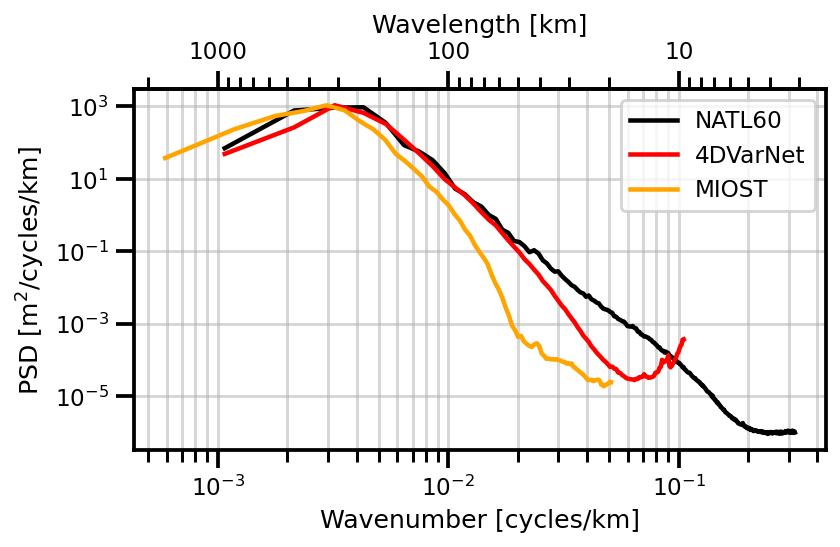

In [126]:
fig, ax = plt.subplots()

ax.plot( 
    (wavenumber["natl60"]*1e3),
    psd["natl60"],
    label="NATL60", color="black"
)

ax.plot( 
    (wavenumber["4dvarnet"]*1e3),
    psd["4dvarnet"],
    label="4DVarNet", color="red"
)


ax.plot( 
    (wavenumber["miost"]*1e3),
    psd["miost"],
    label="miost".upper(), color="orange"
)

ax.set(
    yscale="log", xscale="log",
    xlabel="Wavenumber [cycles/km]",
    ylabel="PSD [m$^{2}$/cycles/km]",
)

secax = ax.secondary_xaxis('top', functions=(lambda x: 1/(x+1e-20), lambda x: 1/(x+1e-20)))
secax.xaxis.set_major_formatter('{x:.0f}')
secax.set(xlabel="Wavelength [km]")


ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()